## Quantum walks and Variational algorithm

* Anton Karazeev &lt;[anton.karazeev@gmail.com](mailto:anton.karazeev@gmail.com)&gt; and Evgeniy Kiktenko &lt;[evgeniy.kiktenko@gmail.com](mailto:evgeniy.kiktenko@gmail.com)&gt;

* Based on: <br>
**Quantum Software Master Class ** <br>
    Lecturer - Jacob Biamonte 
    <br/>
    TA - Timur Tlyachev 
    <br/>
    email: T.Tlyachev@skoltech.ru
    <br/>
    DeepQuantum
    <br/>
    2018 Skoltech


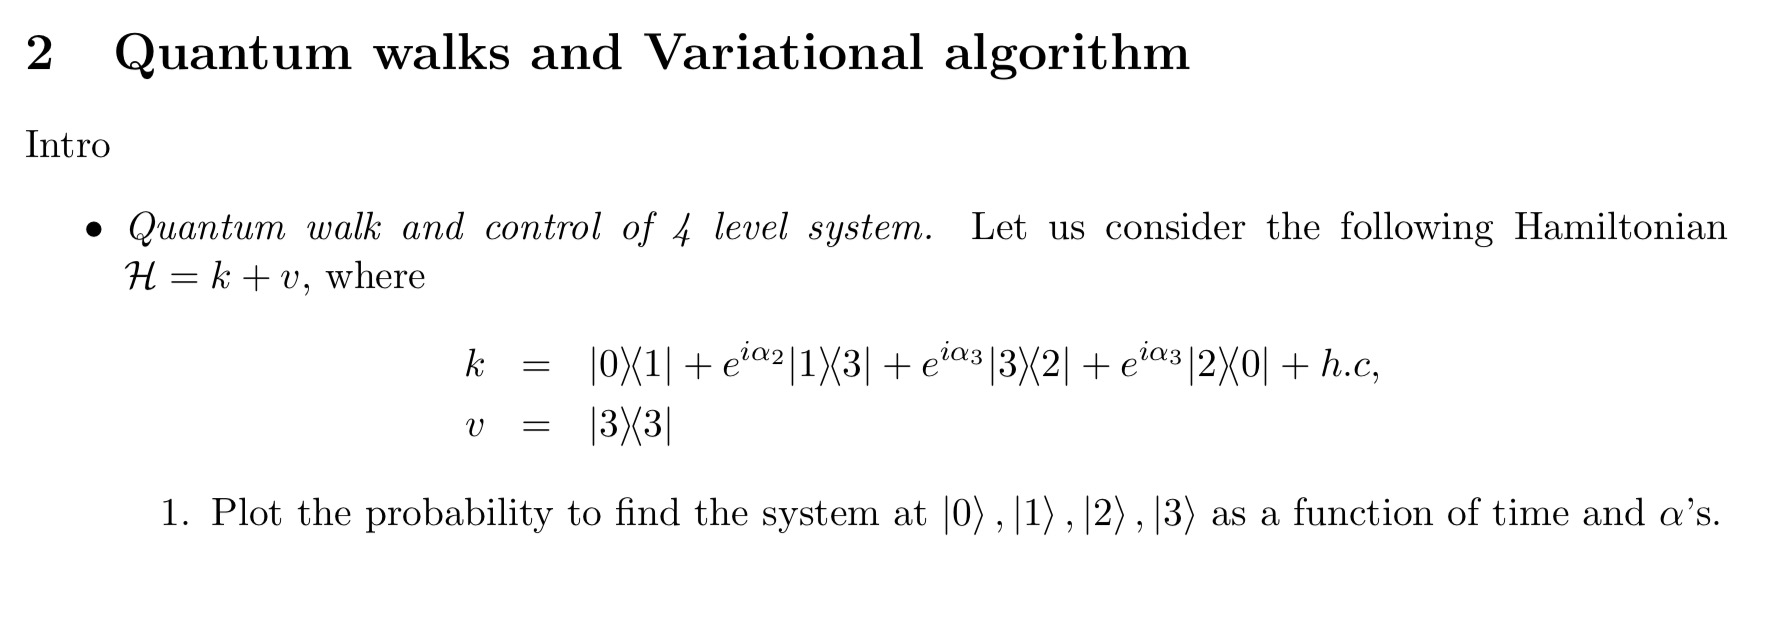

In [155]:
from IPython.display import Image
Image(filename="img1.jpg", width=600)

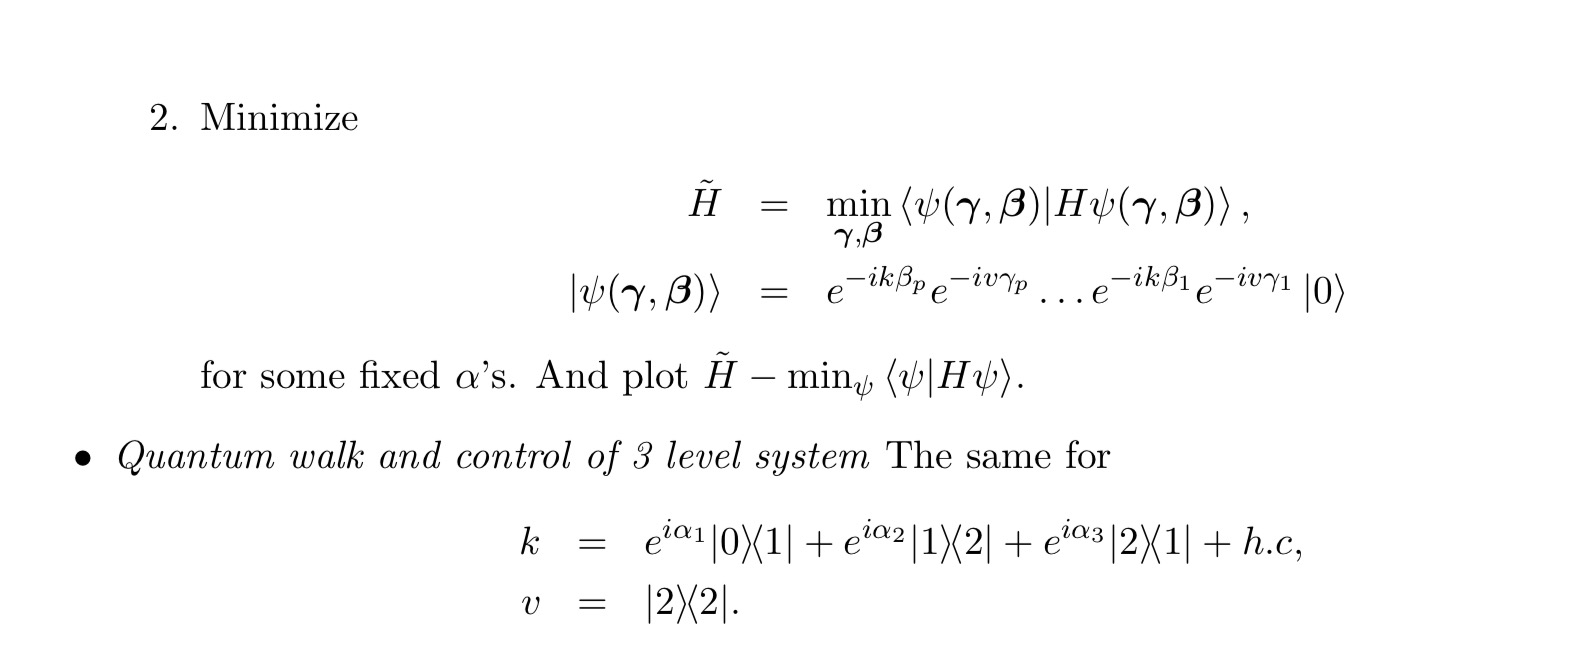

In [156]:
Image(filename="img2.jpg", width=600)

# Quantum walks and Variational algorithm

Algorithm steps:
* minimize Hamiltonian $h$ over states for  and find this $\min\langle\psi\vert h\psi\rangle$
where
$$
\vert\psi\rangle= e^{-i*k*params[2p-1]}e^{-i*k*params[2p-2]}\ldots e^{-i*k*params[1]}e^{-i*k*params[0]}\vert\text{ini_state}\rangle
$$
* prepare state
* Realize phase estimation algorith to find lowest energy in the

In [1]:
# import packages
import qit
import numpy as np
import scipy.linalg as la
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from random import randint
import scipy
%matplotlib inline

We are looking for the ground state and ground level energy of the following Hamiltonian (4 level andom walk):
$$h=k+v,$$
where
$$k=e^{i\alpha_0}\vert0\rangle\langle1\vert+e^{i\alpha_1}\vert1\rangle\langle3\vert+e^{i\alpha_2}\vert3\rangle\langle2\vert+e^{i\alpha_3}\vert2\rangle\langle0\vert+h.c,$$
and 
$$v=\vert3\rangle\langle3\vert.$$

In [2]:
# Define states by using qit.state. dim=4, since the system is 4 level.
zero_state=qit.state('0',dim=4)
one_state=qit.state('1', dim=4)
two_state=qit.state('2', dim=4)
three_state=qit.state('3', dim=4)


# Function to generate Hamiltonian = k + v.
def Hamiltonian(alpha: list):
    h = np.exp(1j*alpha[0]) * qit.lmap(np.outer(zero_state.data,one_state.data.ravel())) \
        + np.exp(1j*alpha[1]) * qit.lmap(np.outer(one_state.data,three_state.data.ravel()))\
        + np.exp(1j*alpha[2]) * qit.lmap(np.outer(three_state.data,two_state.data.ravel()))\
        + np.exp(1j*alpha[3]) * qit.lmap(np.outer(two_state.data,zero_state.data.ravel()))
    return h + qit.lmap.ctranspose(h) + qit.state.projector(three_state)

First of all we plot the probability to find the system in time t at the three_state if the system starts from zero_state. To this end we use operation
```python
u_propagate(la.expm(Hamiltonian(alpha).data*1j*(-t)))
```
which returns state $\vert\psi(t)\rangle=e^{-iht}\vert0\rangle$
```python
qit.fidelity(state_1,state_2)
```
returns $\vert\langle \text{state_1}\vert\text{state_2}\rangle\vert$.

In [27]:
# Probability to find system in time t at the one of the states if the
# system starts from zero_state.
def probability(alpha: list, t):
    """
    return 4 probabilities
    """
    state = zero_state.u_propagate(la.expm(Hamiltonian(alpha).data*1j*(-t)))
    return [qit.fidelity(state, zero_state)**2,
            qit.fidelity(state, one_state)**2,
            qit.fidelity(state, two_state)**2,
            qit.fidelity(state, three_state)**2]

assert sum(probability([1,1,1,1], 1)) == 1.0

Use the following parameterization: $\overrightarrow\alpha = [\alpha_0, 2\alpha_0, 3\alpha_0, 4\alpha_0]$

In [10]:
# Calculate probability for different alpha and t.
alpha_x = np.linspace(0, np.pi, 100)
time_y = np.linspace(0, 10, 500)

X, Y = np.meshgrid(alpha_x,time_y)
df = pd.DataFrame(data={'alpha': X.ravel(), 'time': Y.ravel()})

df['probability'] = df.apply(lambda x: probability([x.alpha, 2*x.alpha,
                                                    3*x.alpha, 4*x.alpha],
                                                   x.time), axis=1)

In [11]:
for i in range(4):
    df['prob{}'.format(i)] = list(map(lambda x: x[i], df['probability']))
    
df.head()

,alpha,time,probability,prob0,prob1,prob2,prob3
0,0.000000,0.0,"[1.0, 0.0, 0.0, 0.0]",1.0,0.0,0.0,0.0
1,0.031733,0.0,"[1.0, 0.0, 0.0, 0.0]",1.0,0.0,0.0,0.0
2,0.063467,0.0,"[1.0, 0.0, 0.0, 0.0]",1.0,0.0,0.0,0.0
3,0.095200,0.0,"[1.0, 0.0, 0.0, 0.0]",1.0,0.0,0.0,0.0
4,0.126933,0.0,"[1.0, 0.0, 0.0, 0.0]",1.0,0.0,0.0,0.0


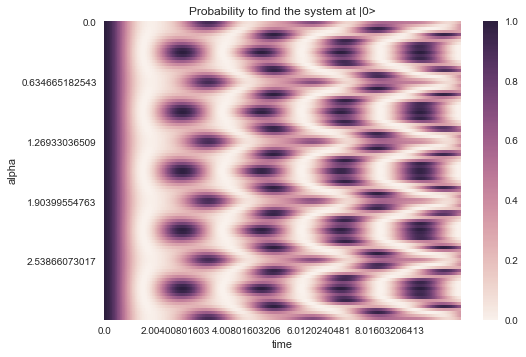

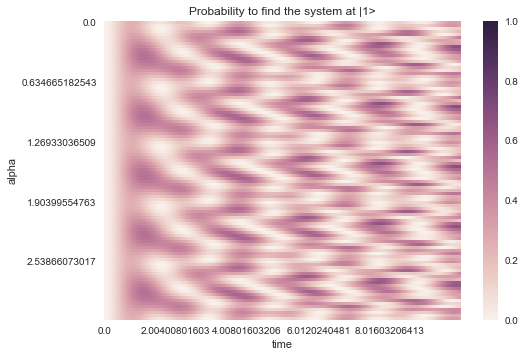

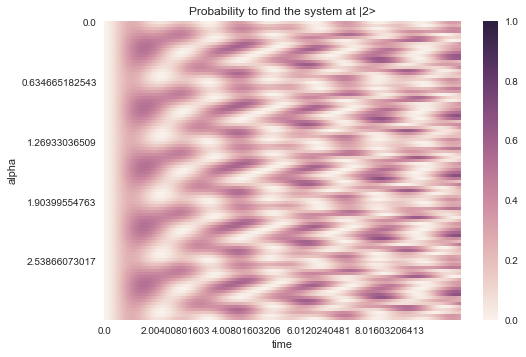

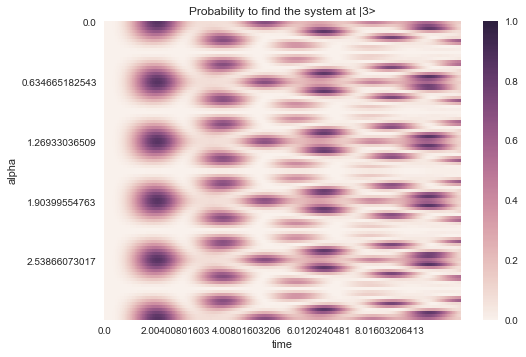

In [12]:
# Plot probability as a function of alpha and t.
import seaborn as sns

for i in range(4):
    data=df.pivot('alpha', 'time', 'prob{}'.format(i))

    sns.heatmap(data, vmin=0, vmax=1, xticklabels=100, yticklabels=20,)
    plt.title('Probability to find the system at |{}>'.format(i))
    plt.show()

### Variational solver

Lets fix $\overrightarrow\alpha = [0.5, 0.6, 0.7, 0.8]$ and define $k$ and $v$

In [13]:
alpha = [0.5, 0.6, 0.7, 0.8]

pre_k = np.exp(1j*alpha[0]) * qit.lmap(np.outer(zero_state.data,one_state.data.ravel()))\
        + np.exp(1j*alpha[1]) * qit.lmap(np.outer(one_state.data,three_state.data.ravel()))\
        + np.exp(1j*alpha[2]) * qit.lmap(np.outer(three_state.data,two_state.data.ravel()))\
        + np.exp(1j*alpha[3]) * qit.lmap(np.outer(two_state.data,zero_state.data.ravel()))

k = pre_k + qit.lmap.ctranspose(pre_k)
v = qit.state.projector(three_state)

function
```python
variational_step(state, params)
```
returns $e^{-i*k*params[1]}e^{-i*v*params[0]}\vert\text{state}\rangle$, which corresponds to $e^{-i*k*\gamma}e^{-i*v*\beta}\vert\text{state}\rangle$

In [15]:
def variational_step(state, params):
    state = state.propagate(v.data, params[0])
    return state.propagate(k.data, params[1])  

function
```python
F_function(p, params, ini_state)
```
returns the expectation value of Hamiltonian
$$ 
\langle\psi\vert h\psi\rangle,
$$
where
$$
\vert\psi\rangle= e^{-i*k*params[2p-1]}e^{-i*k*params[2p-2]}\ldots e^{-i*k*params[1]}e^{-i*k*params[0]}\vert\text{ini_state}\rangle
$$
and returns $\vert\psi\rangle$

In [16]:
def F_function(p, params, ini_state):
    """
    p - number of steps
    """
    global alpha
    
    for i in range(p):
        ini_state = variational_step(ini_state, params=[params[2*i], params[2*i+1]])  # gamma and beta
    return ini_state.ev(Hamiltonian(alpha=alpha).data), ini_state

function
```python
get_params(p, ini_state)
```
returns the array of params which minimizes the expectation value of Hamiltonian
$$ 
\min_{params}\langle\psi(\text{params})\vert h\psi(\text{params})\rangle,
$$

In [17]:
def get_params(p, ini_state):
    # Function to optimimize.
    def fun(x):
        # We minimize f to find max for F.
        return F_function(p=p, ini_state=ini_state, params=x)[0]
    
    # Starting point.
    params_0   = [0.25 * np.pi for i in range(2*p)]
    params_min = [0 for i in range(2*p)]
    params_max = [2*np.pi if i%2 == 0 else np.pi for i in range(2*p)]
    
    # The bounds required by L-BFGS-B.
    bounds = [(low, high) for low, high in zip(params_min, params_max)]

    # Use method L-BFGS-B because the problem is smooth and bounded.
    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds)

    result = scipy.optimize.basinhopping(fun, params_0, minimizer_kwargs=minimizer_kwargs)

    return result.x

Calculate
$$ 
\min_{params}\langle\psi(\text{params})\vert h\psi(\text{params})\rangle,
$$
for different number of iterations p, if initial state is zero_state

In [18]:
%%time
h_ev = []
iteration = []

# Changing p.
for i in range(1, 6):
    h_ev.append(F_function(p=i, params=get_params(i, zero_state), ini_state=zero_state)[0])
    iteration.append(i)
    print(i)

1
2
3
4
5
CPU times: user 3min 52s, sys: 1.81 s, total: 3min 54s
Wall time: 3min 59s


Plot $$\min_{params}\langle\psi(\text{params})\vert h\psi(\text{params})\rangle$$ as a function of $p$

In [19]:
h_ev = np.array(h_ev)

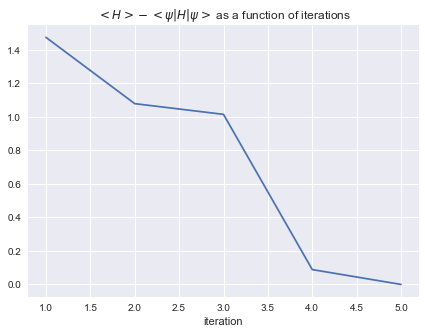

In [21]:
eigenvalue, eigenvectors = np.linalg.eigh(Hamiltonian(alpha).data)

plt.figure(figsize=(7,5))
plt.plot(iteration, h_ev - eigenvalue[0])  # Subtract lowest eigenvalue of H
plt.title('$<H> - <\psi|H|\psi>$ as a function of iterations')
plt.xlabel('iteration')

plt.show()

Let us fix $\psi$ as function that minimizes
$$ 
\min_{params}\langle\psi(\text{params})\vert h\psi(\text{params})\rangle,
$$
at step $p=5$

In [22]:
psi = F_function(5, get_params(5, ini_state=zero_state), ini_state=zero_state)[1]
psi

 +(0.6338+0.1911j) |0> +(-0.5064-0.03706j) |1> +(-0.3492-0.3687j) |2> +(0.1893+0.1017j) |3>
dim: (4,) <- (1,)

# Quantum Walk and Control of 3 level system

We are looking for the ground state and ground level energy of the following Hamiltonian (3 level andom walk):
$$h=k+v,$$
where
$$k=e^{i\alpha_0}\vert0\rangle\langle1\vert+e^{i\alpha_1}\vert1\rangle\langle2\vert+e^{i\alpha_2}\vert2\rangle\langle0\vert+h.c,$$
and 
$$v=\vert2\rangle\langle2\vert.$$

In [24]:
# Function to generate Hamiltonian = k + v.
def Hamiltonian(alpha: list):
    h = np.exp(1j*alpha[0]) * qit.lmap(np.outer(zero_state.data,one_state.data.ravel())) \
        + np.exp(1j*alpha[1]) * qit.lmap(np.outer(one_state.data,two_state.data.ravel()))\
        + np.exp(1j*alpha[2]) * qit.lmap(np.outer(two_state.data,zero_state.data.ravel()))
    return h + qit.lmap.ctranspose(h) + qit.state.projector(two_state)

In [28]:
# Probability to find system in time t at the one of the states if the
# system starts from zero_state.
def probability(alpha: list, t):
    """
    return 3 probabilities
    """
    state = zero_state.u_propagate(la.expm(Hamiltonian(alpha).data*1j*(-t)))
    return [qit.fidelity(state, zero_state)**2,
            qit.fidelity(state, one_state)**2,
            qit.fidelity(state, two_state)**2]

assert sum(probability([1,1,1], 1)) == 1.0

Use the following parameterization: $\overrightarrow\alpha = [\alpha_0, 2\alpha_0, 3\alpha_0]$

In [29]:
# Calculate probability for different alpha and t.
alpha_x = np.linspace(0, np.pi, 100)
time_y = np.linspace(0, 10, 500)

X, Y = np.meshgrid(alpha_x,time_y)
df = pd.DataFrame(data={'alpha': X.ravel(), 'time': Y.ravel()})

df['probability'] = df.apply(lambda x: probability([x.alpha, 2*x.alpha, 3*x.alpha],
                                                   x.time), axis=1)

In [30]:
for i in range(3):
    df['prob{}'.format(i)] = list(map(lambda x: x[i], df['probability']))
    
df.head()

,alpha,time,probability,prob0,prob1,prob2
0,0.000000,0.0,"[1.0, 0.0, 0.0]",1.0,0.0,0.0
1,0.031733,0.0,"[1.0, 0.0, 0.0]",1.0,0.0,0.0
2,0.063467,0.0,"[1.0, 0.0, 0.0]",1.0,0.0,0.0
3,0.095200,0.0,"[1.0, 0.0, 0.0]",1.0,0.0,0.0
4,0.126933,0.0,"[1.0, 0.0, 0.0]",1.0,0.0,0.0


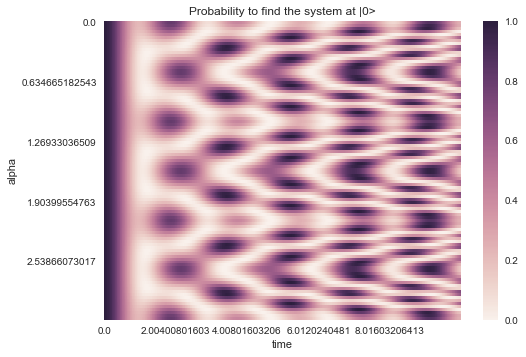

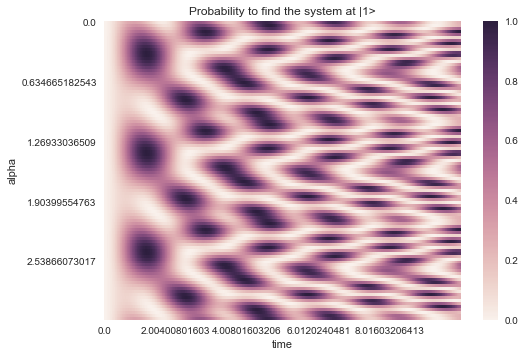

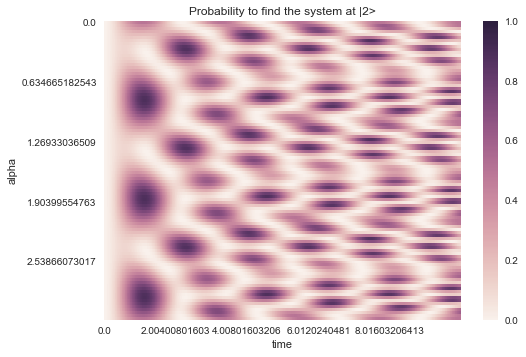

In [31]:
# Plot probability as a function of alpha and t.
import seaborn as sns

for i in range(3):
    data=df.pivot('alpha', 'time', 'prob{}'.format(i))

    sns.heatmap(data, vmin=0, vmax=1, xticklabels=100, yticklabels=20,)
    plt.title('Probability to find the system at |{}>'.format(i))
    plt.show()

Lets fix $\overrightarrow\alpha = [0.5, 0.6, 0.7]$ and define $k$ and $v$

In [32]:
alpha = [0.5, 0.6, 0.7]

pre_k = np.exp(1j*alpha[0]) * qit.lmap(np.outer(zero_state.data,one_state.data.ravel()))\
        + np.exp(1j*alpha[1]) * qit.lmap(np.outer(one_state.data,two_state.data.ravel()))\
        + np.exp(1j*alpha[2]) * qit.lmap(np.outer(two_state.data,zero_state.data.ravel()))

k = pre_k + qit.lmap.ctranspose(pre_k)
v = qit.state.projector(two_state)

In [33]:
def variational_step(state, params):
    state = state.propagate(v.data, params[0])
    return state.propagate(k.data, params[1])  


def F_function(p, params, ini_state):
    """
    p - number of steps
    """
    global alpha
    
    for i in range(p):
        ini_state = variational_step(ini_state, params=[params[2*i], params[2*i+1]])  # gamma and beta
    return ini_state.ev(Hamiltonian(alpha=alpha).data), ini_state


def get_params(p, ini_state):
    # Function to optimimize.
    def fun(x):
        # We minimize f to find max for F.
        return F_function(p=p, ini_state=ini_state, params=x)[0]
    
    # Starting point.
    params_0   = [0.25 * np.pi for i in range(2*p)]
    params_min = [0 for i in range(2*p)]
    params_max = [2*np.pi if i%2 == 0 else np.pi for i in range(2*p)]
    
    # The bounds required by L-BFGS-B.
    bounds = [(low, high) for low, high in zip(params_min, params_max)]

    # Use method L-BFGS-B because the problem is smooth and bounded.
    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds)

    result = scipy.optimize.basinhopping(fun, params_0, minimizer_kwargs=minimizer_kwargs)

    return result.x

In [34]:
%%time
h_ev = []
iteration = []

# Changing p.
for i in range(1, 6):
    h_ev.append(F_function(p=i, params=get_params(i, zero_state), ini_state=zero_state)[0])
    iteration.append(i)
    print(i)

1
2
3
4
5
CPU times: user 2min 15s, sys: 1.07 s, total: 2min 16s
Wall time: 2min 21s


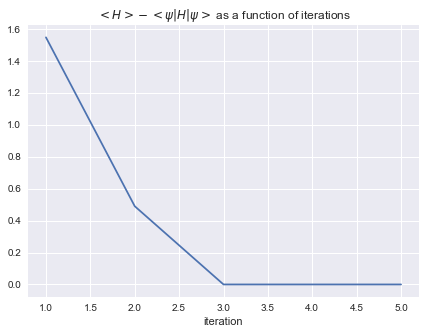

In [35]:
h_ev = np.array(h_ev)

eigenvalue, eigenvectors = np.linalg.eigh(Hamiltonian(alpha).data)

plt.figure(figsize=(7,5))
plt.plot(iteration, h_ev - eigenvalue[0])  # Subtract lowest eigenvalue of H
plt.title('$<H> - <\psi|H|\psi>$ as a function of iterations')
plt.xlabel('iteration')

plt.show()

In [36]:
psi = F_function(5, get_params(5, ini_state=zero_state), ini_state=zero_state)[1]
psi

 +(-0.4905+0.4045j) |0> +(0.02767-0.6352j) |1> +(0.3815+0.2145j) |2>
dim: (4,) <- (1,)